# Analyzing the result of the model error experiment

In [84]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper

path = '../../dgym-data/analysis/noise/noise-2024-04-17_17-49-55.zip'

records = []
with zipfile.ZipFile(path, 'r') as z:
    for filename in tqdm(z.namelist()):
        if filename.endswith('.json'):
            with z.open(filename) as file:
                with TextIOWrapper(file, encoding='utf-8') as text_file:
                    try:
                        result = json.load(text_file)
                        record = {'sigma': result['sigma'], 'cost': result['cost'], 'outcome': result.get('outcome', 0)}
                        records.append(record)
                        result = None
                    except:
                        continue

df = pd.DataFrame(records)
records = None

  0%|          | 0/4200 [00:00<?, ?it/s]

(-0.05, 1.05)

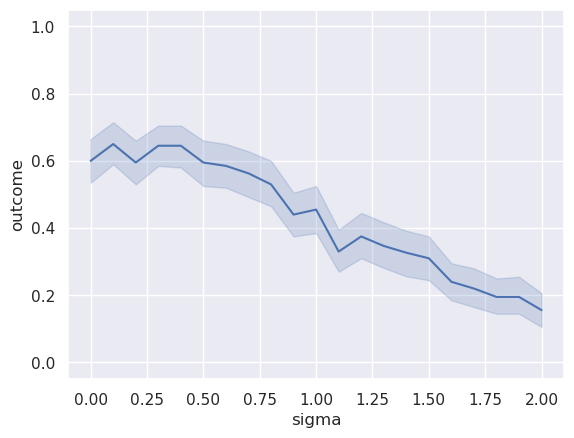

In [85]:
import seaborn as sns

sns.set()
sns.lineplot(df, x='sigma', y='outcome')

plt.ylim(-0.05, 1.05)

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Determine the maximum cost to extend the eCDF
max_cost = df['cost'].max()
timeline = np.linspace(0, max_cost, 3_000)

ecdfs = []
for idx, (sigma, group) in enumerate(df.groupby('sigma')):
    
    # if idx % 4 == 0:

    # Create Kaplan-Meier object
    kmf = KaplanMeierFitter()

    # Fit data
    kmf.fit(durations=group['cost'], event_observed=group['outcome'], timeline=timeline)
    ecdf = pd.merge(
        kmf.cumulative_density_,
        right=kmf.confidence_interval_cumulative_density_,
        left_index=True,
        right_index=True
    ).reset_index()
    ecdf['sigma'] = sigma
 
    # Transform survival function to eCDF
    ecdfs.append(ecdf)

Text(0.5, 1.0, 'Cumulative probability of success versus model error ($\\sigma$)')

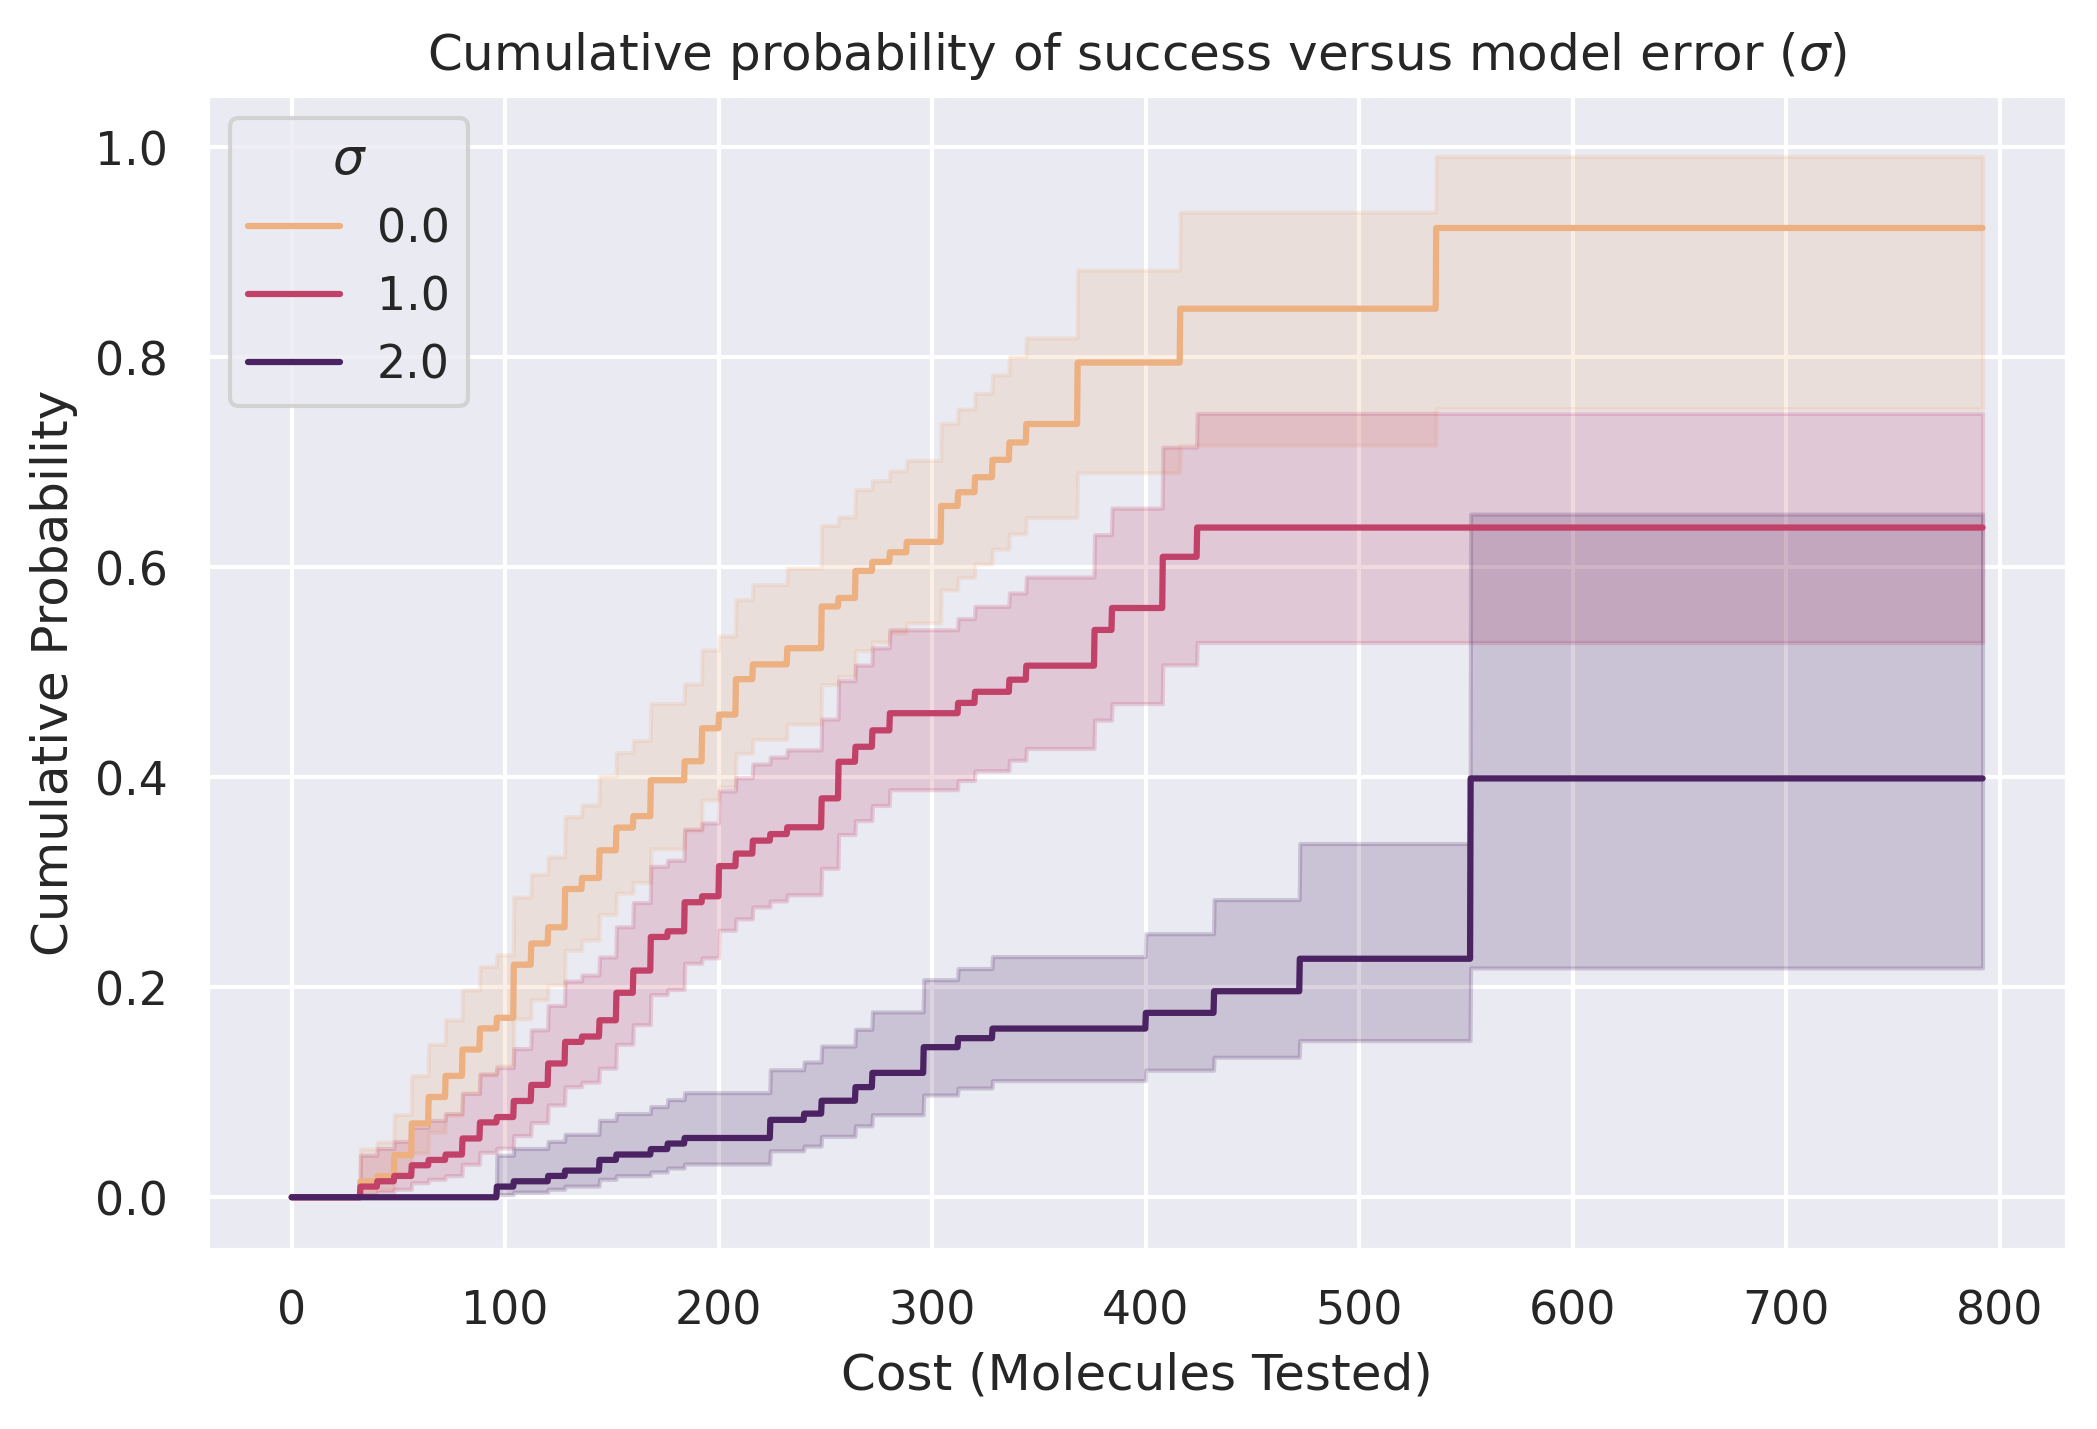

In [87]:
plt.figure(figsize=(8, 5), dpi=300)

interval = 1.0

ecdf = pd.concat(ecdfs)
g = sns.lineplot(
    ecdf.query(f'sigma % {interval} == 0'),
    x='timeline',
    y='KM_estimate',
    hue='sigma',
    palette='flare'
)

colormap = sns.palettes.get_colormap('flare')
colors = colormap.resampled(len(ecdf.query(f'sigma % {interval} == 0').groupby('sigma')))

for idx, (name, group) in enumerate(ecdf.query(f'sigma % {interval} == 0').groupby('sigma')):
    g.fill_between(
        group['timeline'],
        group['KM_estimate_lower_0.95'],
        group['KM_estimate_upper_0.95'],
        alpha=0.2,
        color=colors.colors[idx]
    )

plt.legend(title='$\sigma$')
plt.xlabel('Cost (Molecules Tested)')
plt.ylabel('Cumulative Probability')
plt.ylim(-0.05, 1.05)
plt.title('Cumulative probability of success versus model error ($\sigma$)')

Plot a single line.

Text(0.5, 1.0, 'Cumulative prob. of success versus model error ($\\sigma$) | Budget = 200 molecules')

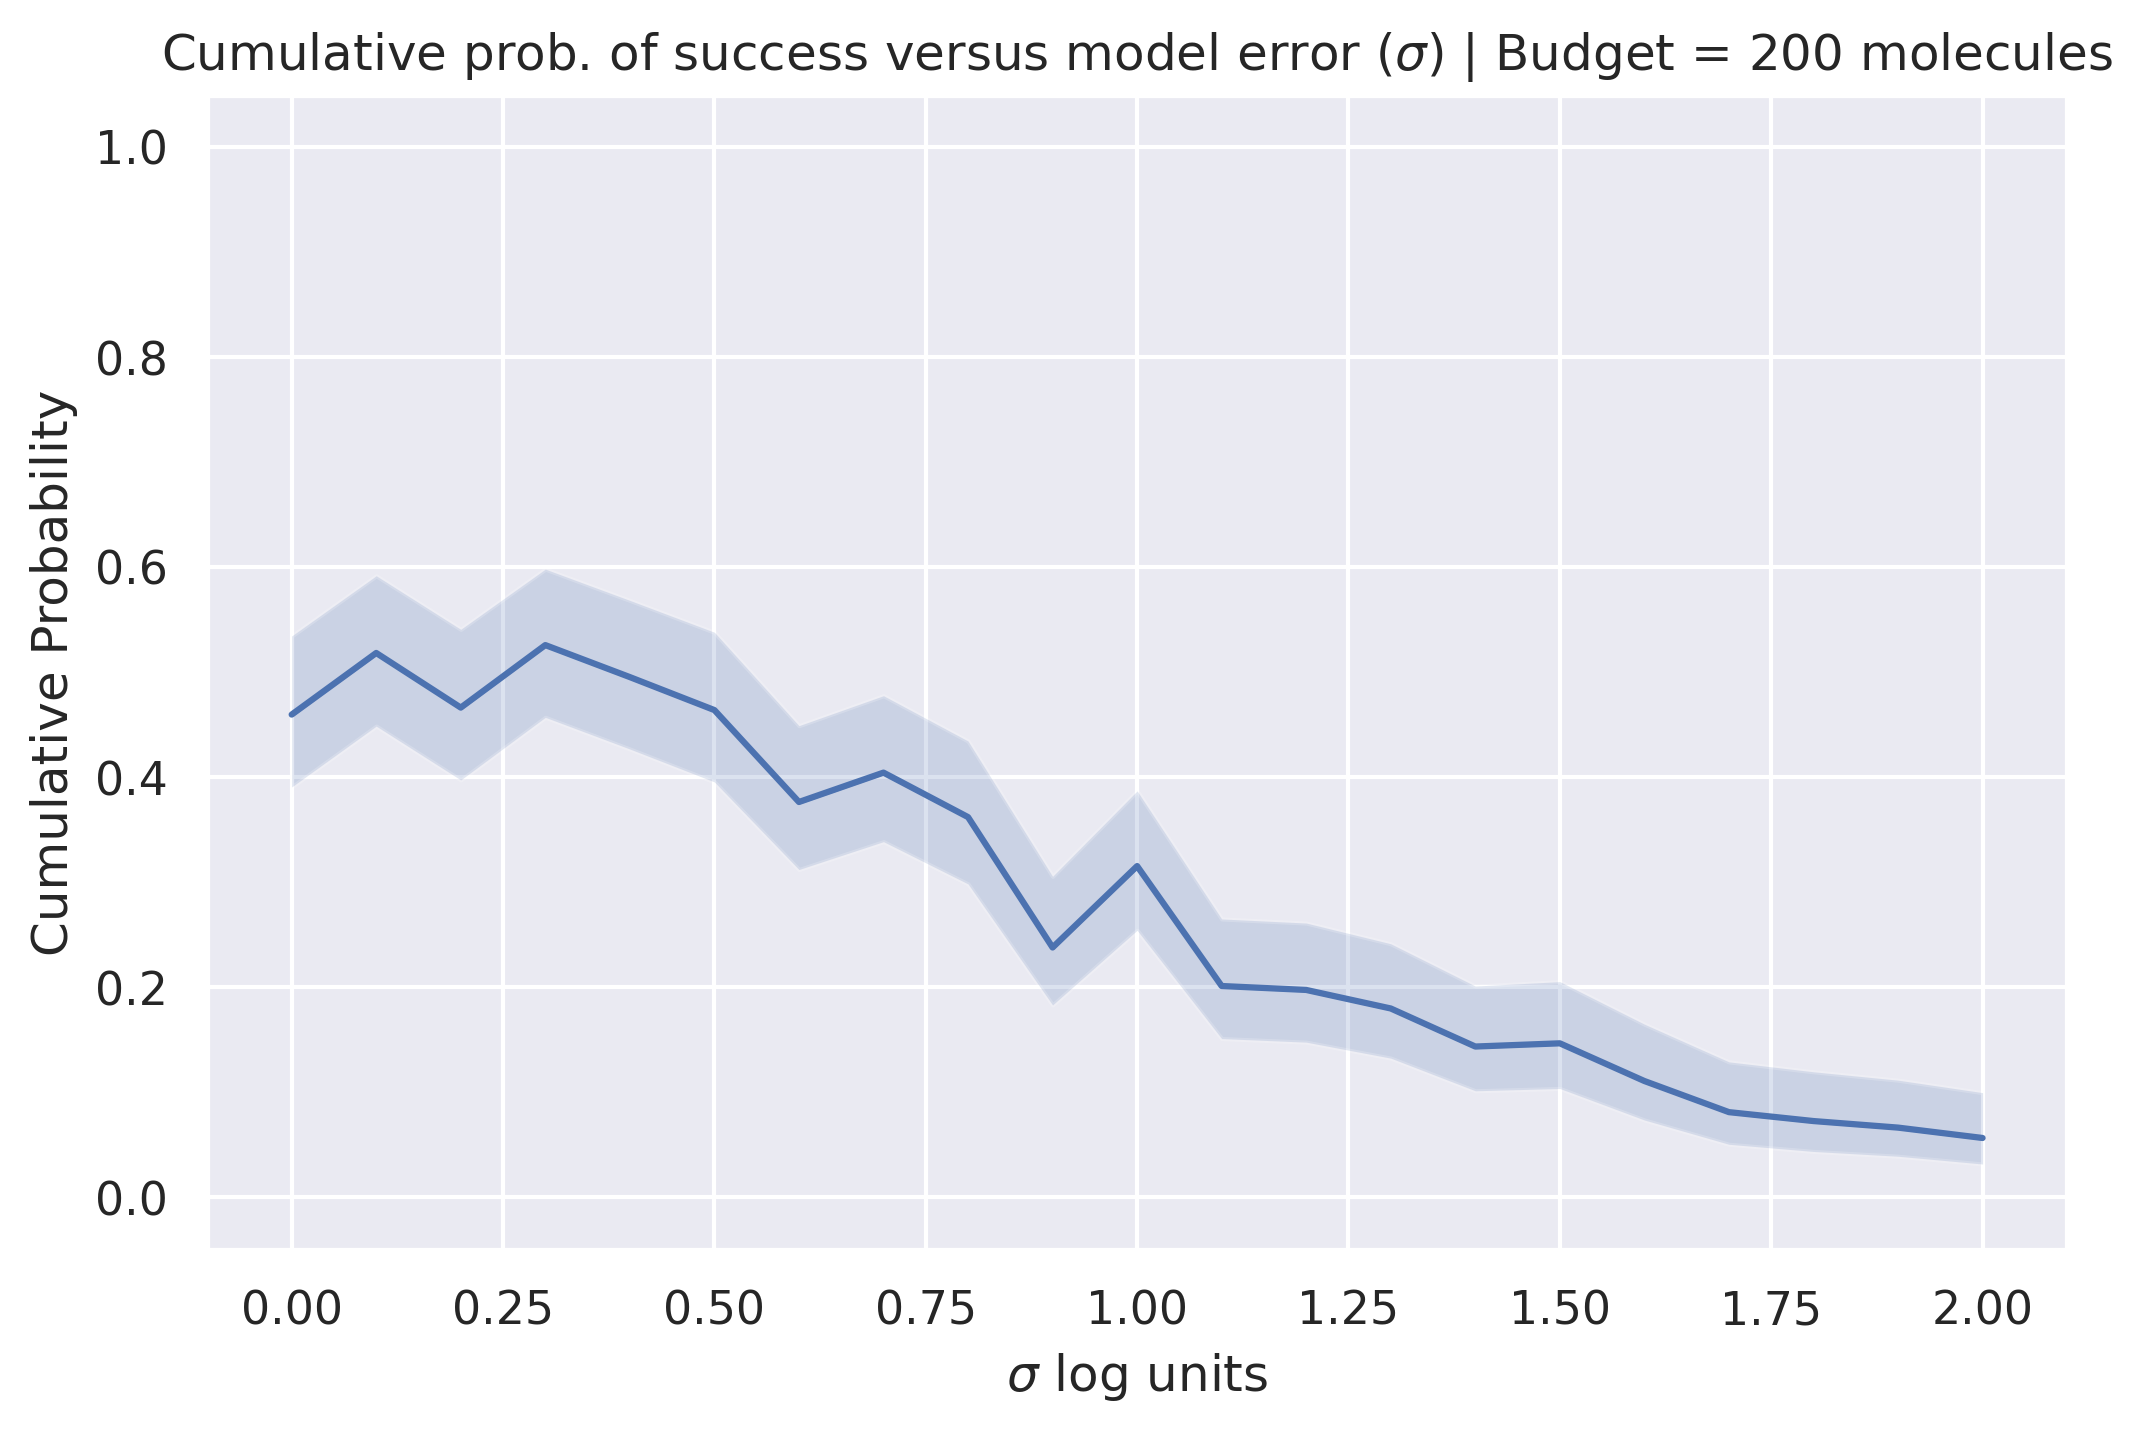

In [88]:
plt.figure(figsize=(8, 5), dpi=300)

budget = 200
filtered = ecdf.query(f'{budget} < timeline < {budget} + 5.0')
g = sns.lineplot(
    filtered,
    x='sigma',
    y='KM_estimate',
)

g.fill_between(
    filtered['sigma'],
    filtered['KM_estimate_lower_0.95'],
    filtered['KM_estimate_upper_0.95'],
    alpha=0.2,
)

plt.ylim(-0.05, 1.05)
plt.xlabel('$\sigma$ log units')
plt.ylabel('Cumulative Probability')
plt.title(f'Cumulative prob. of success versus model error ($\sigma$) | Budget = {budget} molecules')

Plotting costs? Doesn't really work because the data are censored.

In [131]:
filtered_low['timeline']

sigma
0.0    212.062688
0.1    191.991997
0.2    204.008003
0.3    179.975992
0.4    183.937312
0.5    208.101367
0.6    243.885295
0.7    251.939980
0.8    267.917306
0.9    295.910637
1.0    319.942648
1.1    584.030677
1.2    423.993331
1.3    592.085362
1.4    684.120040
1.5    608.062688
Name: timeline, dtype: float64

In [ ]:
plt.figure(figsize=(8, 5), dpi=300)

prob_success = 0.25
filtered = ecdf.query(f'{prob_success} - 0.05 < KM_estimate < {prob_success} + 0.05')
filtered_low = ecdf.query(f'{prob_success} - 0.05 < `KM_estimate_lower_0.95` < {prob_success} + 0.05')
filtered_high = ecdf.query(f'{prob_success} - 0.05 < `KM_estimate_upper_0.95` < {prob_success} + 0.05')

filtered_mean = filtered.groupby('sigma').agg({'timeline': 'mean'})
filtered_low = filtered_low.groupby('sigma').agg({'timeline': 'mean'})
filtered_high = filtered_high.groupby('sigma').agg({'timeline': 'mean'})

g = sns.lineplot(
    filtered_mean,
    x='sigma',
    y='timeline',
)

max_ci_length = min(len(filtered_mean), len(filtered_low), len(filtered_high))
g.fill_between(
    filtered_mean.index[:max_ci_length],
    filtered_low['timeline'].iloc[:max_ci_length],
    filtered_high['timeline'].iloc[:max_ci_length],
    alpha=0.2,
)

plt.ylim(0)
plt.xlim(-0.05, 2.05)
plt.xlabel('$\sigma$ log units')
plt.ylabel('Cost')
plt.title(f'Expected cost versus model error ($\sigma$) | Probability of Success = {prob_success * 100}%')

Text(0.5, 1.0, 'Expected cost versus model error ($\\sigma$) | Probability of Success = 25.0%')